## Generate fake data...

In [4]:
# Initializes a dataframe with injuries
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random

def generate_fake_injury_data(n_individuals = 12, time_span = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3):
    fake = Faker()
    end_date = datetime.today()
    start_date = end_date - timedelta(days=int(time_span * 365))
    date_range = pd.date_range(start=start_date, end=end_date)
    
    data = []
    
    for user_id in range(1, n_individuals + 1):
        user_name = fake.name()
        currently_injured = False
        injury_end_date = None
        injury_idx = None
        
        for date in date_range:
            injury_onset = False
            
            if not currently_injured and np.random.rand() < injury_onset_incidence:
                injury_onset = True
                duration = max(1, int(np.random.normal(injury_duration_mean, injury_duration_std)))
                injury_end_date = date + timedelta(days=duration)
                currently_injured = True
                injury_idx = f'{user_id}_{date.strftime("%d_%m_%Y")}'
            
            if currently_injured and date >= injury_end_date:
                currently_injured = False
                injury_end_date = None
                injury_idx = None
            
            data.append([user_id, user_name, date, injury_onset, currently_injured, injury_idx])
    
    df = pd.DataFrame(data, columns=["user_id", "user_name", "date", "injury_onset", "currently_injured", 'injury_idx'])

    return df

# Example usage:
injury_data = generate_fake_injury_data(n_individuals = 12, time_span = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3)

C:\Users\rmeer\AppData\Local\Temp\ipykernel_16088\1139373628.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# Construct a useful feature that tracks how many days until the next injury
def add_days_until_next_injury(df_user_id):
     df_user_id['days_until_next_injury'] = np.nan
     for injury_idx in df_user_id['injury_idx'].unique():
          if str(injury_idx) == 'nan' or injury_idx is None:
               continue
          cur_injury = df_user_id.loc[df_user_id['injury_idx'] == injury_idx,:]
          cur_injury_date = cur_injury['date'].iloc[0]
          prior_to_injury_bool = (df_user_id['date'] <= cur_injury_date) & (df_user_id['days_until_next_injury'].isnull())
          delta_time = cur_injury_date - df_user_id['date']
          df_user_id.loc[prior_to_injury_bool, 'days_until_next_injury'] = delta_time.loc[prior_to_injury_bool].dt.days
               
     return df_user_id

injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury).reset_index(drop=True)

C:\Users\rmeer\AppData\Local\Temp\ipykernel_16088\1470953112.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury).reset_index(drop=True)


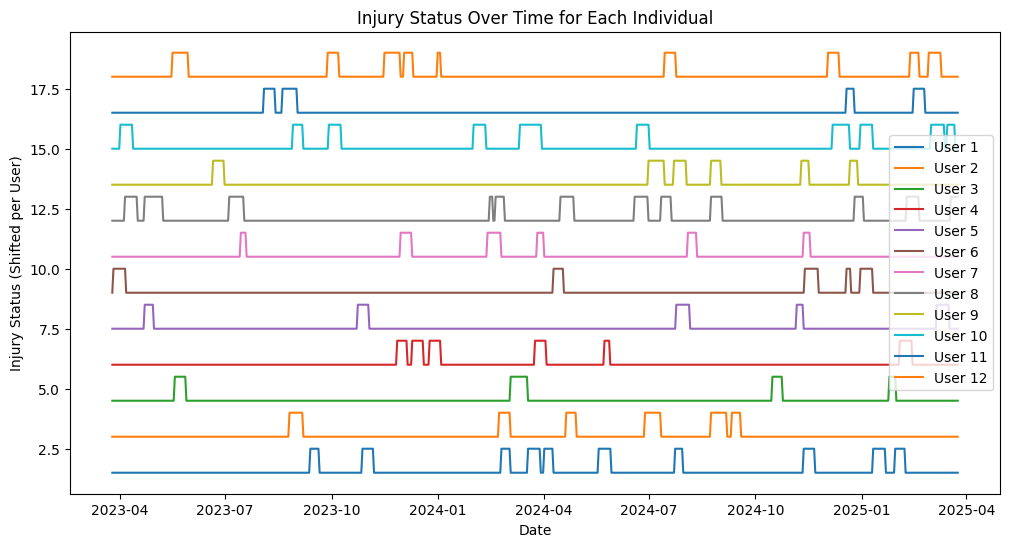

In [6]:
# For exploration purposes, plot when an individual is injured (works for relatively small numbers (<15 ish))
def plot_injury_status(df):
    plt.figure(figsize=(12, 6))
    for user_id in df["user_id"].unique():
        user_data = df[df["user_id"] == user_id]
        plt.plot(user_data["date"], user_data["currently_injured"].astype(int) + user_id * 1.5, label=f'User {user_id}')
    
    plt.xlabel("Date")
    plt.ylabel("Injury Status (Shifted per User)")
    plt.title("Injury Status Over Time for Each Individual")
    plt.legend()
    plt.show()
    return

plot_injury_status(injury_data)

In [7]:
# Add training load data (with or without bias)
# Define RPE tables with percentage distribution for each RPE value
rpe_tables = {
     'polarized': {
            1: 0.10, 2: 0.40, 3: 0.30, 4: 0.05, 5: 0.05, 6: 0.03, 7: 0.03, 8: 0.02, 9: 0.01, 10: 0.01
        },
     'pyramidal': {
            1: 0.10, 2: 0.20, 3: 0.20, 4: 0.15, 5: 0.15, 6: 0.10, 7: 0.05, 8: 0.03, 9: 0.01, 10: 0.01
        }
        }
training_per_week = {
    0: 0.03, 1: 0.06, 2: 0.12, 3: 0.23, 4: 0.26, 5: 0.22, 6: 0.06, 7: 0.02
}
def generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='polarized', introduce_bias_n_days_before = None, max_pct_bias = None):
    """
    Generate training load data based on existing injury data.
    The training load will be assigned only on days when the user is not injured.
    
    Parameters:
    - injury_data: DataFrame generated by `generate_fake_injury_data`
    - rpe_table: Choose 'polarized' or 'pyramidal' RPE table (default is 'polarized')
    
    Returns:
    - DataFrame with training load data.
    """
    
    # Select RPE table based on user input
    if rpe_table_type == 'polarized':
        pass
    elif rpe_table_type == 'pyramidal':
        pass
    elif rpe_table_type == 'randomly_assigned_per_user_id':
        pass
    else:
        raise ValueError("Invalid rpe_table_type. Choose 'randomly_assigned_per_user_id', 'polarized', or 'pyramidal'.")
    
    df = injury_data.copy()
    df['rpe'] = np.nan
    df['duration_minutes'] = np.nan
    df['training_distribution'] = ''

    # Loop over each user in the injury data
    for user_id in df['user_id'].unique():
        user_injury_data = df[df['user_id'] == user_id]

        cur_rpe_table_type = rpe_table_type
        if rpe_table_type == 'randomly_assigned_per_user_id':
            cur_rpe_table_type = np.random.choice(list(rpe_tables.keys()))            

        rpe_table = rpe_tables[cur_rpe_table_type]

        df.loc[user_injury_data.index, 'training_distribution'] = cur_rpe_table_type

        # For each row in the injury data (one row per day)
        cur_week = -1
        for idx, row in user_injury_data.iterrows():

            if cur_week != row['date'].week:
                # A new week
                cur_week = row['date'].week
                # Determine which weekdays will be practice days
                n_training_days = np.random.choice(list(training_per_week.keys()), p=list(training_per_week.values()))
                training_days = random.sample(range(8), n_training_days)

            if row['currently_injured']:
                continue  # Skip days when the user is injured
            if not row['date'].weekday() in training_days:
                continue # Skip day as not part of random subset of training days
            
            # Generate training load on days when the user is not injured
            rpe = np.random.choice(list(rpe_table.keys()), p=list(rpe_table.values()))

            soon_to_be_injured_bias = 1
            if not introduce_bias_n_days_before is None:
                if row['days_until_next_injury'] <= introduce_bias_n_days_before:
                    pct_increase = (introduce_bias_n_days_before - row['days_until_next_injury']) / introduce_bias_n_days_before * 100
                    soon_to_be_injured_bias += pct_increase / max_pct_bias

            # Determine training duration based on RPE
            if rpe <= 5:
                duration = np.random.randint(75*soon_to_be_injured_bias, 121*soon_to_be_injured_bias)  # 75-120 minutes for RPE 1-5
            elif rpe <= 8:
                duration = np.random.randint(45*soon_to_be_injured_bias, 91*soon_to_be_injured_bias)  # 45-90 minutes for RPE 6-8
            else:
                duration = np.random.randint(30*soon_to_be_injured_bias, 61*soon_to_be_injured_bias)  # 30-60 minutes for RPE 9-10
            
            df.loc[idx, 'rpe'] = rpe
            df.loc[idx, 'duration_minutes'] = duration

            continue # End of for loop to iterate over current user_id
        continue # End of for loop to iterate over the different user_ids

    return df

training_load_data = generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='randomly_assigned_per_user_id')
biased_training_load_data = generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='randomly_assigned_per_user_id', introduce_bias_n_days_before = 28, max_pct_bias = 100)



In [39]:
# Add wellness data (with or without bias)
# Define wellness scores with percentage distribution for each item
wellness_tables = {
    'Energy Score': {
        1: 0.00459, 2: 0.00917, 3: 0.01835, 4: 0.05505, 5: 0.13761, 6: 0.27523, 
        7: 0.34404, 8: 0.13303, 9: 0.01835, 10: 0.00458
    },
    'Mood Score': {
        1: 0.00398, 2: 0.00797, 3: 0.01195, 4: 0.02390, 5: 0.07171, 6: 0.15936, 
        7: 0.39841, 8: 0.23904, 9: 0.05976, 10: 0.02392
    },
    'Recovery Score': {
        1: 0.00377, 2: 0.00755, 3: 0.01509, 4: 0.06038, 5: 0.13208, 6: 0.26415, 
        7: 0.30189, 8: 0.15094, 9: 0.05283, 10: 0.01132
    },
    'Motivation Score': {
        1: 0.01064, 2: 0.00709, 3: 0.01064, 4: 0.02128, 5: 0.06383, 6: 0.14184, 
        7: 0.35461, 8: 0.28369, 9: 0.07092, 10: 0.03546
    },
    'Confidence Score': {
        1: 0.00057, 2: 0.00229, 3: 0.00458, 4: 0.01145, 5: 0.05727, 6: 0.22910, 
        7: 0.45819, 8: 0.21764, 9: 0.01031, 10: 0.00860
    },
    'Sleep Quality Score': {
        1: 0.00426, 2: 0.00851, 3: 0.01702, 4: 0.03404, 5: 0.10213, 6: 0.21277, 
        7: 0.34043, 8: 0.17021, 9: 0.10213, 10: 0.00850
    }
}

def generate_fake_wellness_data_from_injury(injury_data, introduce_bias_n_days_before = None, max_pct_bias = None):
    """
    Generate wellness data based on existing injury data.
    The wellness will be assigned only on days when the user is not injured.
    
    Parameters:
    - injury_data: DataFrame generated by `generate_fake_injury_data`
    - wellness_tables: Choose 'polarized' or 'pyramidal' RPE table (default is 'polarized')
    
    Returns:
    - DataFrame with training load data.
    """
  
    df = injury_data.copy()
    df[list(wellness_tables.keys())] = np.nan

    # Loop over each user in the injury data
    for user_id in df['user_id'].unique():
        user_injury_data = df[df['user_id'] == user_id]

        # For each row in the injury data (one row per day)
        cur_week = -1
        for idx, row in user_injury_data.iterrows():

            if cur_week != row['date'].week:
                # A new week
                cur_week = row['date'].week
                # Determine which weekdays will be practice days
                n_training_days = np.random.choice(list(training_per_week.keys()), p=list(training_per_week.values()))
                training_days = random.sample(range(8), n_training_days)

            if row['currently_injured']:
                continue  # Skip days when the user is injured
            if not row['date'].weekday() in training_days:
                continue # Skip day as not part of random subset of training days
            
            for item_key in wellness_tables.keys():                
                item_table = wellness_tables[item_key]
                
                # Generate training load on days when the user is not injured
                item_val_before = np.random.choice(list(item_table.keys()), p=list(item_table.values()))
                item_val = item_val_before
                soon_to_be_injured_bias = 1
                if not introduce_bias_n_days_before is None:
                    if row['days_until_next_injury'] <= introduce_bias_n_days_before:
                        pct_decrease = (introduce_bias_n_days_before - row['days_until_next_injury']) / introduce_bias_n_days_before * 100
                        soon_to_be_injured_bias -= pct_decrease / max_pct_bias            
                
                item_val = np.round((item_val-1) * soon_to_be_injured_bias,0)+1 # -1 en +1 om te voorkomen dat 't 0 wordt
                # if item_val_before != item_val:
                #     print(f'Adjusted {item_val_before:.0f} to {item_val:.0f} (with {row["days_until_next_injury"]} days_until_next_injury)')

                df.loc[idx, item_key] = item_val

            continue # End of for loop to iterate over current user_id
        continue # End of for loop to iterate over the different user_ids

    return df

training_load_en_wellness_data = generate_fake_wellness_data_from_injury(training_load_data)
biased_training_load_en_wellness_data = generate_fake_wellness_data_from_injury(training_load_data, introduce_bias_n_days_before = 28, max_pct_bias = 100)

## Feature Construction

In [56]:
# Construct some useful (and typical) features
def compute_sRPE(df, rpe_col = 'rpe', duration_col = 'duration_minutes', srpe_col = 'session_rpe'):
     # sRPE
     df[srpe_col] = df[rpe_col] * df[duration_col]
     return df
###########
# Wellness Average
def compute_wellness_avg(df, existing_wellness_cols):     
     df.loc[:, 'Wellness Average'] = df.loc[:, existing_wellness_cols].mean(axis = 1)
     return df
###########
def compute_load_sum(df, load_col, n_days_prev, date_col = 'date', user_id_col = 'user_id'):
     """
     Sums the values in the last `n_days_prev` previous days of column `load_col` for each `user_id_col`.

     Parameters:
     df (pd.DataFrame): The input dataframe.
     user_id_col (str): The column name for user ID.
     date_col (str): The column name for date.
     load_col (str): The column name for load values.
     n_days_prev (int): The number of previous days to sum.

     Returns:
     pd.DataFrame: DataFrame with summed values for each user_id and date.
     """
     sum_col = '%s_SUM_%.2d_days' %(load_col, n_days_prev)	
     std0_col = '%s_STD0_%.2d_days' %(load_col, n_days_prev)	     
     df = df.sort_values(by=[user_id_col, date_col])  # Sort by user and date

     for user_id, group in df[[date_col, user_id_col, load_col]].groupby(user_id_col):
          # Assumes complete data: an entry for every day an athlete is available
          group['orig_index'] = group.index
          group = group.set_index(date_col).sort_index()       
          
          # Compute rolling sum and standard deviation
          group[sum_col] = group[load_col].rolling(f'{n_days_prev}D', closed='left').sum()
          group[std0_col] = group[load_col].rolling(f'{n_days_prev}D', closed='left').std(ddof=0).fillna(0)
          
          since_start = group.index - group.index.min()
          group.loc[since_start.days < n_days_prev, sum_col] = np.nan
          group.loc[since_start.days < n_days_prev, std0_col] = np.nan

          group[user_id_col] = user_id  # Reintroduce user_id column
          group.reset_index().rename(columns={'index': date_col})
          group = group.set_index('orig_index')
          
          df.loc[group.index, group.columns] = group
     return df, sum_col, std0_col

###########
def compute_acwr_mon_str(df, n_days_prev_acute = 7, n_days_prev_chronic = 28, load_col = 'session_rpe'):
     # ACWR, Strain, Monotony
     acr_col = '%s_AC%.2d_%.2d_days' %(load_col, n_days_prev_acute, n_days_prev_chronic)
     monotony_col = '%s_MON_%.2d_days' %(load_col,  n_days_prev_chronic)	
     strain_col = '%s_STR_%.2d_days' %(load_col, n_days_prev_chronic)	

     df, acute_sum_col, acute_std0_col = compute_load_sum(df, load_col, n_days_prev_acute)
     df, chronic_sum_col, chronic_std0_col = compute_load_sum(df, load_col, n_days_prev_chronic)

     df[acr_col] = (df[acute_sum_col] / n_days_prev_acute) / (df[chronic_sum_col] / n_days_prev_chronic)
     df[monotony_col] = (df[chronic_sum_col] / n_days_prev_chronic) / df[chronic_std0_col]
     df[strain_col] = df[chronic_sum_col] * df[monotony_col]
     return df
###########
def feature_construction(df):
     # A collection of to-be-constructed features
     df = compute_sRPE(df, rpe_col = 'rpe', duration_col = 'duration_minutes', srpe_col = 'session_rpe')
     df = compute_wellness_avg(df, list(wellness_tables.keys()))
     df = compute_acwr_mon_str(df, n_days_prev_acute = 7, n_days_prev_chronic = 28, load_col = 'session_rpe')
     return df
###########

training_load_en_wellness_data = feature_construction(training_load_en_wellness_data)
biased_training_load_en_wellness_data = feature_construction(biased_training_load_en_wellness_data)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
      dtype='int64', name='date', length=731)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
      dtype='int64', name='date', length=731)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
      dtype='int64', name='date', length=731)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
      dtype='int64', name='date', length=731)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
      dtype='int64', name='date', length=731)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
      dtype='i

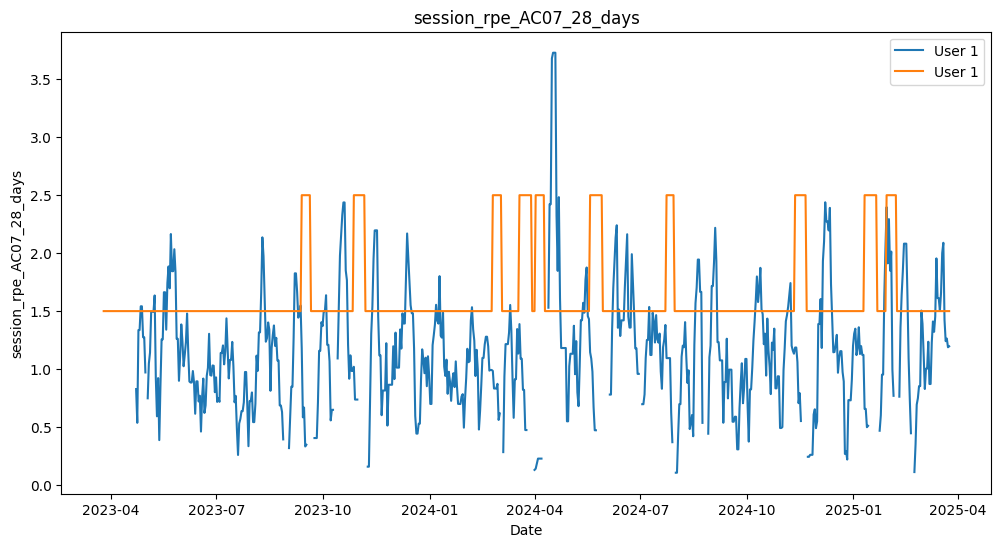

session_rpe_AC07_28_days
0.539326    7
0.618117    7
1.494912    6
0.570432    6
0.439235    6
           ..
1.986097    1
2.031355    1
1.895453    1
1.544569    1
1.300384    1
Name: count, Length: 6325, dtype: int64

In [57]:
# For exploration purposes, plot when an individual is injured (works for relatively small numbers (<15 ish))
def plot_injury_status(df):
    plt.figure(figsize=(12, 6))
    for user_id in df["user_id"].unique():
        user_data = df[df["user_id"] == user_id]
        plt.plot(user_data["date"], user_data["session_rpe_AC07_28_days"], label=f'User {user_id}')
        plt.plot(user_data["date"], user_data["currently_injured"].astype(int) + user_id * 1.5, label=f'User {user_id}')

        break
    
    plt.xlabel("Date")
    plt.ylabel("session_rpe_AC07_28_days")
    plt.title("session_rpe_AC07_28_days")
    plt.legend()
    plt.show()
    return

plot_injury_status(biased_training_load_en_wellness_data)
biased_training_load_en_wellness_data['session_rpe_AC07_28_days'].value_counts()

In [41]:
biased_training_load_en_wellness_data

,user_id,user_name,date,injury_onset,currently_injured,injury_idx,days_until_next_injury,rpe,duration_minutes,training_distribution,...,Motivation Score,Confidence Score,Sleep Quality Score,session_rpe,Wellness Average,session_rpe_SUM_07_days,session_rpe_STD0_07_days,session_rpe_AC07_28_days,session_rpe_MON_28_days,session_rpe_STR_28_days
0,1,Alexis Anderson,2023-03-25 16:09:38.959014,False,False,None,171.0,NaN,NaN,polarized,...,8.0,7.0,7.0,NaN,7.166667,NaN,0.000000,NaN,NaN,NaN
1,1,Alexis Anderson,2023-03-26 16:09:38.959014,False,False,None,170.0,2.0,108.0,polarized,...,4.0,7.0,7.0,216.0,6.333333,NaN,0.000000,NaN,NaN,NaN
2,1,Alexis Anderson,2023-03-27 16:09:38.959014,False,False,None,169.0,NaN,NaN,polarized,...,7.0,7.0,8.0,NaN,6.833333,216.0,0.000000,4.0,inf,inf
3,1,Alexis Anderson,2023-03-28 16:09:38.959014,False,False,None,168.0,2.0,108.0,polarized,...,NaN,NaN,NaN,216.0,NaN,216.0,0.000000,4.0,inf,inf
4,1,Alexis Anderson,2023-03-29 16:09:38.959014,False,False,None,167.0,NaN,NaN,polarized,...,7.0,5.0,6.0,NaN,6.166667,432.0,0.000000,4.0,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,12,Kayla Johnston,2025-03-20 16:09:38.959014,False,False,None,NaN,NaN,NaN,polarized,...,9.0,7.0,9.0,NaN,7.500000,1243.0,122.251544,4.0,0.363127,451.367072
8768,12,Kayla Johnston,2025-03-21 16:09:38.959014,False,False,None,NaN,NaN,NaN,polarized,...,NaN,NaN,NaN,NaN,NaN,1243.0,122.251544,4.0,0.363127,451.367072
8769,12,Kayla Johnston,2025-03-22 16:09:38.959014,False,False,None,NaN,2.0,93.0,polarized,...,7.0,8.0,1.0,186.0,5.500000,916.0,129.464281,4.0,0.252690,231.463733
8770,12,Kayla Johnston,2025-03-23 16:09:38.959014,False,False,None,NaN,NaN,NaN,polarized,...,8.0,6.0,7.0,NaN,6.666667,1024.0,103.894177,4.0,0.352007,360.454685


In [ ]:
# Store the data
training_load_en_wellness_data.to_csv('exported_data.csv')
biased_training_load_en_wellness_data.to_csv('exported_data_biased.csv')

## plots

[1, 3, 4, 5, 6, 7, 12, 2, 8, 9, 10, 11]


<Figure size 1200x800 with 0 Axes>

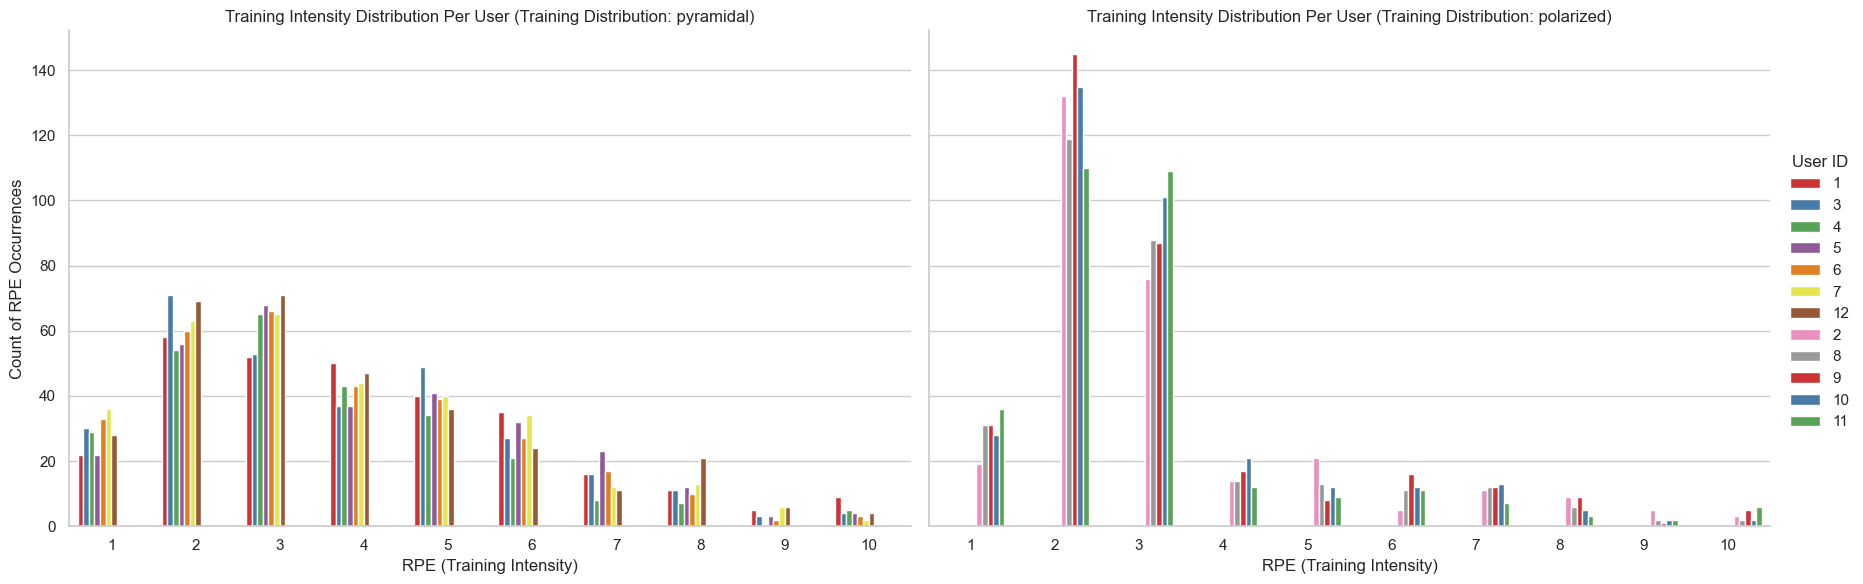

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_intensity_distribution(training_load_data):
    training_data = training_load_data.loc[training_load_data['rpe'].notnull(), :].copy()
    # training_data = training_data.sort_values(by='training_distribution')
    # Ensure 'rpe' is treated as a categorical variable
    training_data['rpe'] = training_data['rpe'].astype(int)

    # Group by user_id, rpe, and training_distribution to count the occurrences
    user_rpe_distribution = training_data.groupby(['user_id', 'rpe', 'training_distribution']).size().reset_index(name='count')
    
    # Define the desired order of user IDs
    users_method_1 = training_data.loc[training_data['training_distribution']==training_data['training_distribution'].unique()[0],'user_id'].unique().tolist()
    users_method_2 = sorted(set(user_rpe_distribution['user_id']) - set(users_method_1))
    user_order = users_method_1 + users_method_2    
    print(user_order)
    # Convert user_id to categorical with the specified order
    user_rpe_distribution['user_id'] = pd.Categorical(user_rpe_distribution['user_id'], categories=user_order, ordered=True)

    # Set up the plot
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    
    # Create the plot, splitting by 'training_distribution'
    g = sns.catplot(x="rpe", y="count", hue="user_id", col="training_distribution", data=user_rpe_distribution,
                    kind="bar", height=6, aspect=1.5, palette="Set1")
    
    g.set_axis_labels("RPE (Training Intensity)", "Count of RPE Occurrences")
    g.set_titles("Training Intensity Distribution Per User (Training Distribution: {col_name})")
    
    # Adjust the legend
    g.legend.set_title("User ID")
    
    plt.show()

# Example Usage:
plot_training_intensity_distribution(training_load_data)


C:\Users\rmeer\AppData\Local\Temp\ipykernel_23772\896334867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['rpe'] = training_data['rpe'].astype(int)
C:\Users\rmeer\AppData\Local\Temp\ipykernel_23772\896334867.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rpe', y='proportion', data=user_rpe_distribution, ax=axes[i], palette="Set1")
C:\Users\rmeer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a le

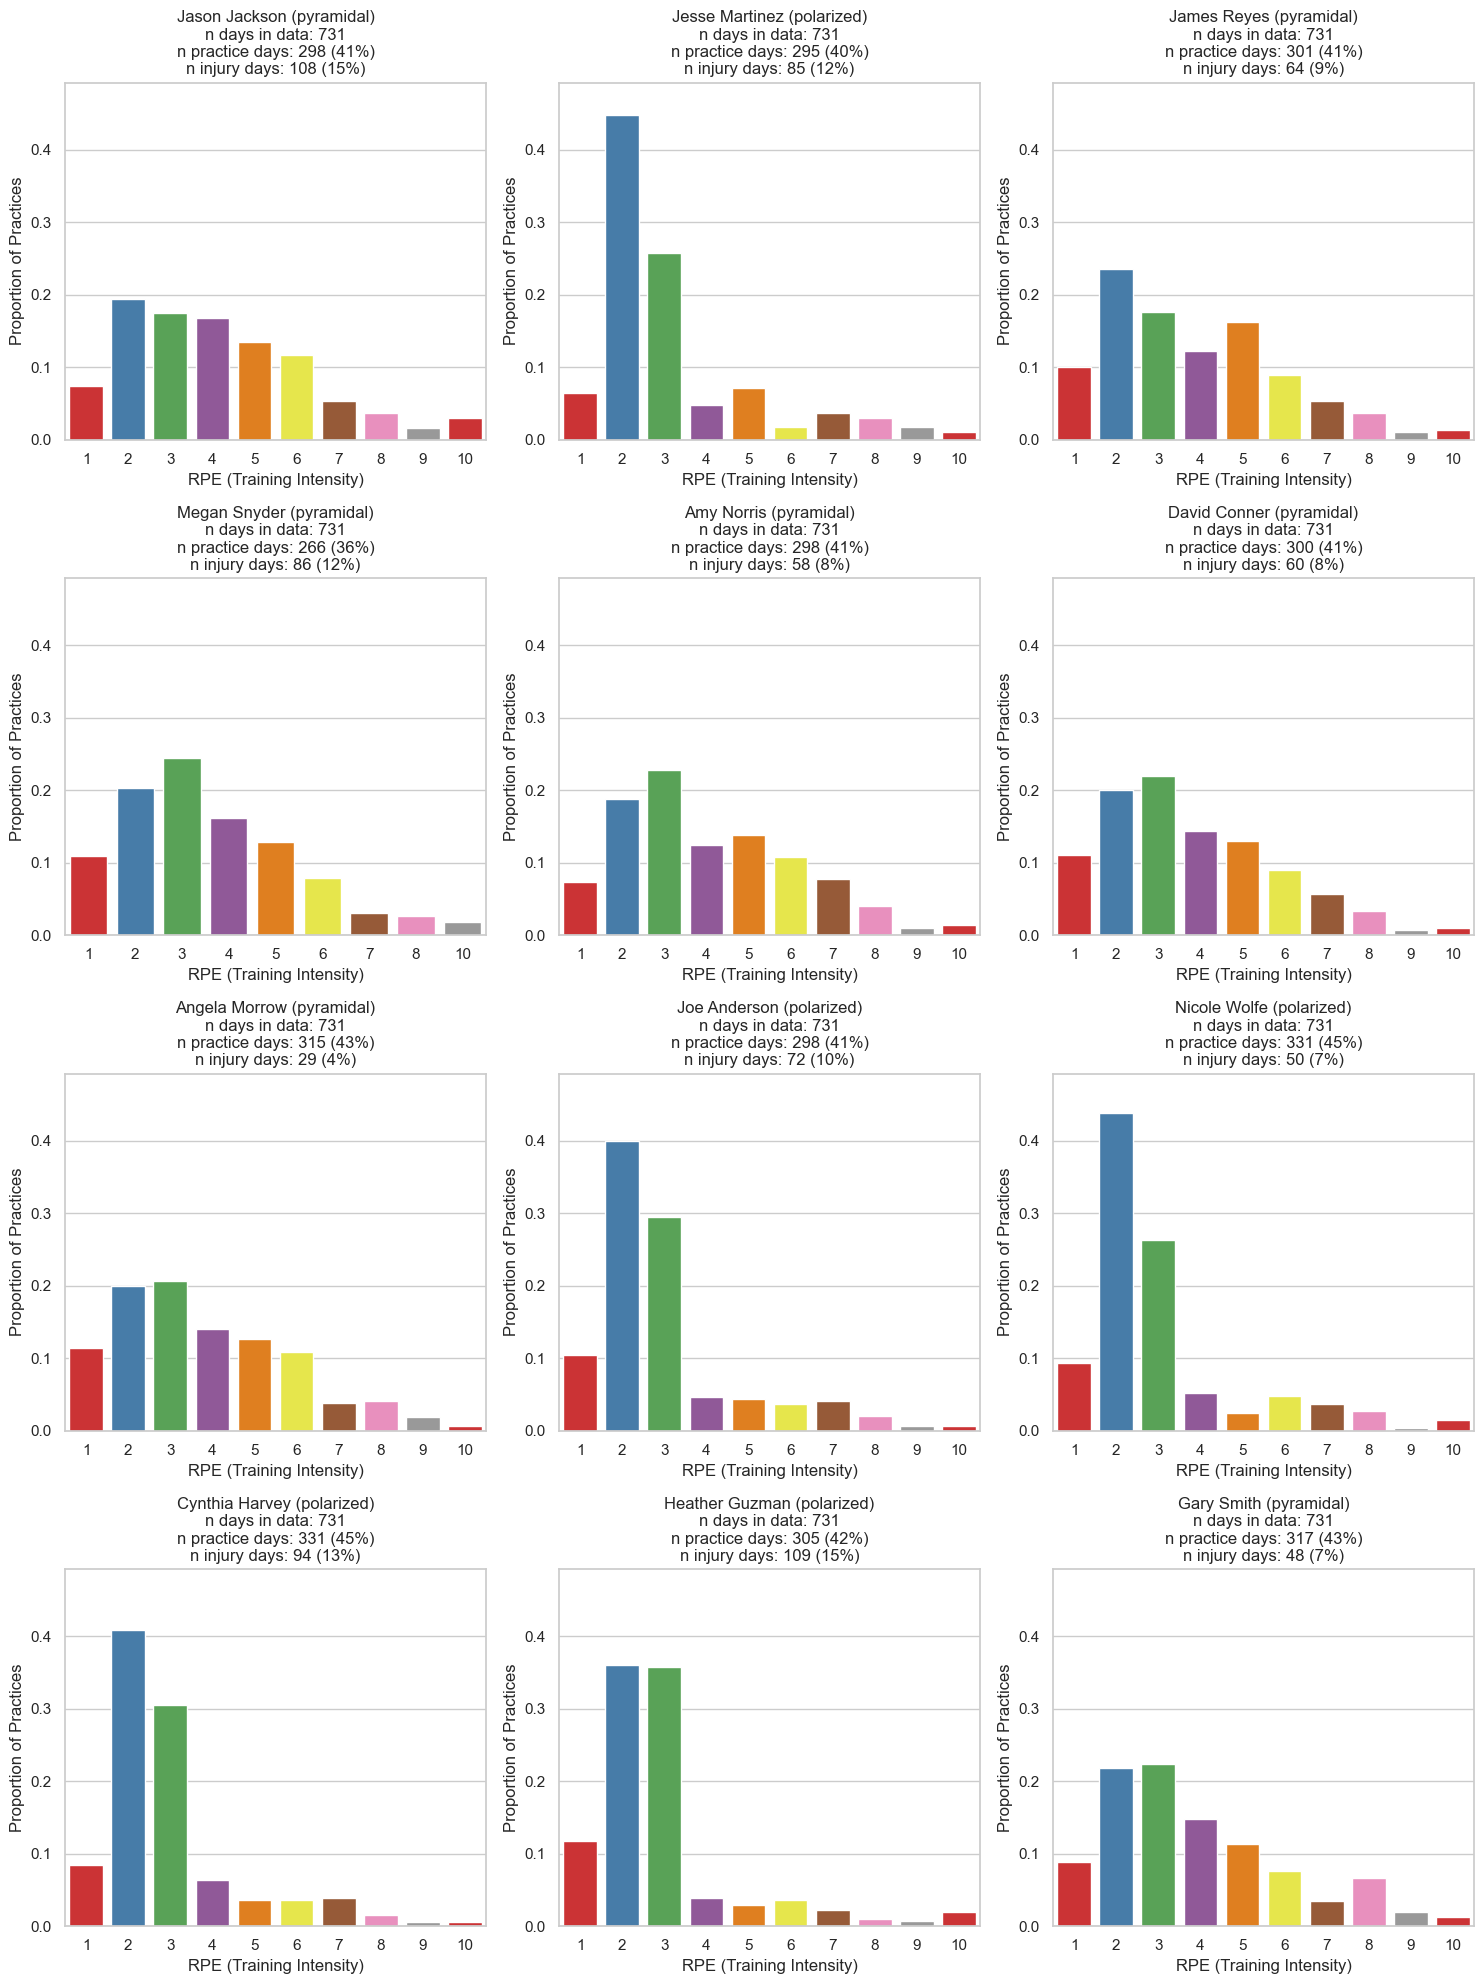

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_intensity_distribution(training_load_data):
    training_data = training_load_data.loc[training_load_data['rpe'].notnull(), :]
    # Ensure 'rpe' is treated as a categorical variable
    training_data['rpe'] = training_data['rpe'].astype(int)

    # Get unique user IDs
    user_ids = training_data['user_id'].unique()

    # Set up the plot grid: create a subplot for each user
    n_users = len(user_ids)
    n_cols = 3  # Number of columns for the subplots
    n_rows = (n_users // n_cols) + (n_users % n_cols > 0)  # Calculate number of rows required

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes for easier indexing

    # Find the maximum proportion across all users
    max_proportion_all_users = 0
    user_max_proportions = {}

    # First, calculate the max proportion for each user to determine global max
    for user_id in user_ids:
        user_data = training_data[training_data['user_id'] == user_id]
        
        # Group by 'rpe' to count the occurrences of each RPE value for the user
        user_rpe_distribution = user_data.groupby('rpe').size().reset_index(name='count')
        
        # Calculate the total number of practices for this user
        total_practices = user_data.shape[0]
        
        # Normalize the counts to get the proportion of each RPE value
        user_rpe_distribution['proportion'] = user_rpe_distribution['count'] / total_practices
        
        # Find the maximum proportion for this user
        user_max_proportion = user_rpe_distribution['proportion'].max()
        user_max_proportions[user_id] = user_max_proportion
        
        # Update the global maximum proportion
        max_proportion_all_users = max(max_proportion_all_users, user_max_proportion)

    # Set up the plot grid and plot the data
    for i, user_id in enumerate(user_ids):
        user_data = training_data[training_data['user_id'] == user_id]
        user_injury_data = training_load_data[training_load_data['user_id'] == user_id]
        
        # Group by 'rpe' to count the occurrences of each RPE value for the user
        user_rpe_distribution = user_data.groupby('rpe').size().reset_index(name='count')
        
        # Calculate the total number of practices for this user
        total_practices = user_data.shape[0]
        
        # Normalize the counts to get the proportion of each RPE value
        user_rpe_distribution['proportion'] = user_rpe_distribution['count'] / total_practices

        # Plot the relative frequency (proportion) for each RPE value
        sns.barplot(x='rpe', y='proportion', data=user_rpe_distribution, ax=axes[i], palette="Set1")
        
        # Add the user name and training_distribution value to the title
        user_name = user_data['user_name'].iloc[0]
        training_distribution = user_data['training_distribution'].iloc[0]
        axes[i].set_title(f"{user_name} ({training_distribution})\nn days in data: {user_injury_data.shape[0]}\nn practice days: {user_injury_data['rpe'].notnull().sum()} ({user_injury_data['rpe'].notnull().sum() / user_injury_data.shape[0]*100:.0f}%)\nn injury days: {sum(user_injury_data['currently_injured']==True)} ({sum(user_injury_data['currently_injured']==True) / user_injury_data.shape[0]*100:.0f}%)", fontsize=12)
        
        # Set axis labels
        axes[i].set_xlabel("RPE (Training Intensity)")
        axes[i].set_ylabel("Proportion of Practices")
        
        # Set the y-axis limits to the same value across all users, based on the observed max proportion
        axes[i].set_ylim(0, max_proportion_all_users * 1.1)  # Add a small buffer (10%)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example Usage:
plot_training_intensity_distribution(training_load_data)
